# 02 Machine Learning / Proyecto

## Credit Card Leads

### Equipo:
- Javier De La Rosa Mondragon
- Luis Fernando Merino Nambo
- Salomon Ramírez

![Leads](credit-cards.jpg)

##  Dataset

Credit Card Lead Prediction

https://www.kaggle.com/datasets/shelvigarg/credit-card-buyers

- ~250,000 filas en train set

- ~100,000 etiquetas en test set

- 10 Features
    - ID
    - Sexo
    - Edad
    - Region
    - Ocupación
    - Channel code
    - Vintage
    - Credit product
    - Balance promedio
    - Activo
    


- 1 Columna de target
    - Lead

## Objetivo

Analizar, limpiar y usar el train dataset para identificar clientes con tendencia a adquirur una tarjeta de crédito tomando como features los datos del cliente y los productos con los que ya cuentan.


## Importación de bibliotecas 

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

## Lectura de datos

In [2]:
creditCardLeadDf = pd.read_csv('data/train-data-credit-card.csv')

In [3]:
creditCardLeadDf.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


## Limpieza y EDA

In [4]:
display(creditCardLeadDf.isna().sum())
print(creditCardLeadDf.shape)

ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         29325
Avg_Account_Balance        0
Is_Active                  0
Is_Lead                    0
dtype: int64

(245725, 11)


In [5]:
# ya que el trainset es muy grande, empezaremos eliminando las filas con datos vaciós
creditCardLeadDf = creditCardLeadDf.dropna()
display(creditCardLeadDf.isna().sum().sum())
print(creditCardLeadDf.shape)

0

(216400, 11)


<Axes: xlabel='Is_Lead', ylabel='count'>

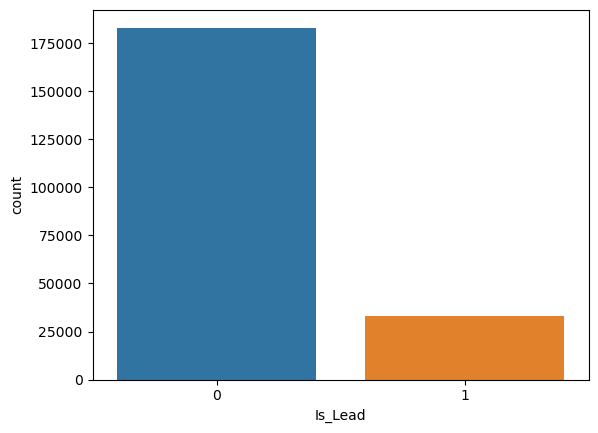

In [6]:
# ya que trabajaremos con clasificación, veamos cuántos casos hay de cada categoría:
sns.countplot(data=creditCardLeadDf, x='Is_Lead')

In [56]:
# Observamos que hay una deproporción muy grande.

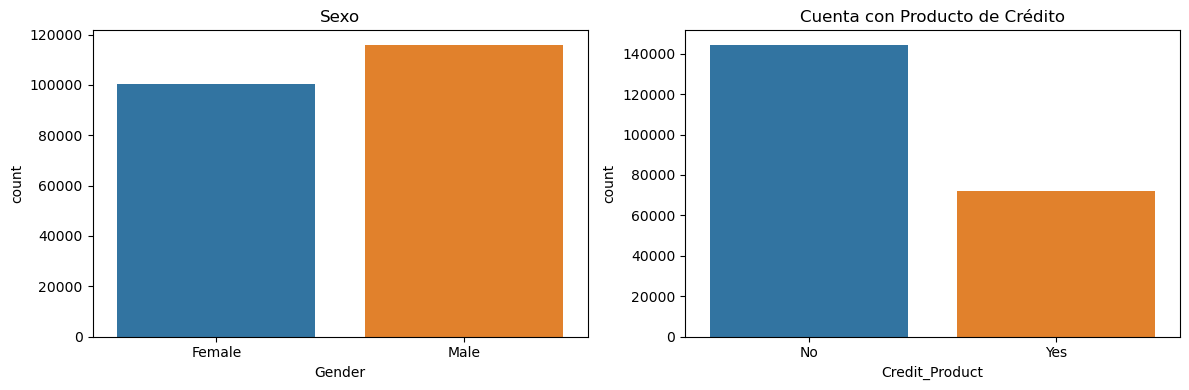

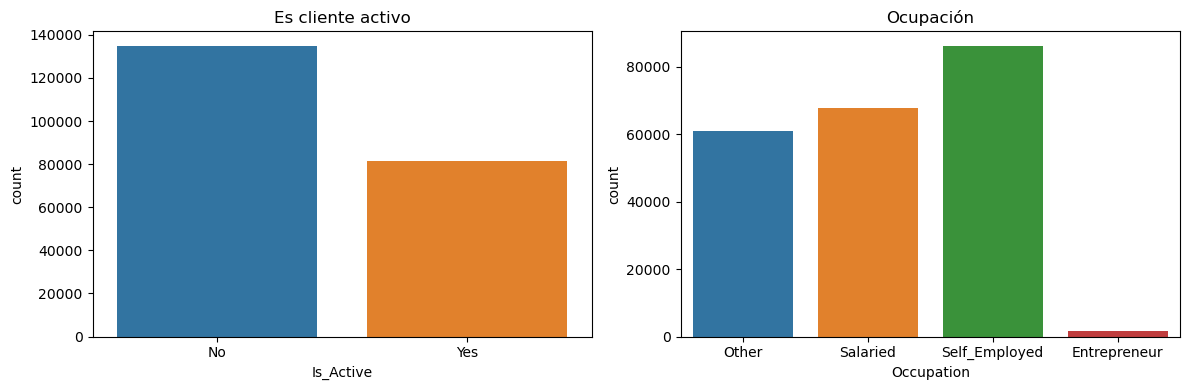

In [55]:
# Veamos las proporciones en algunas variables:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot(data=creditCardLeadDf, x='Gender', ax=axes[0])
axes[0].set_title('Sexo')
sns.countplot(data=creditCardLeadDf, x='Credit_Product', ax=axes[1])
axes[1].set_title('Cuenta con Producto de Crédito')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot(data=creditCardLeadDf, x='Is_Active', ax=axes[0])
axes[0].set_title('Es cliente activo')
sns.countplot(data=creditCardLeadDf, x='Occupation', ax=axes[1])
axes[1].set_title('Ocupación')
plt.tight_layout()
plt.show()

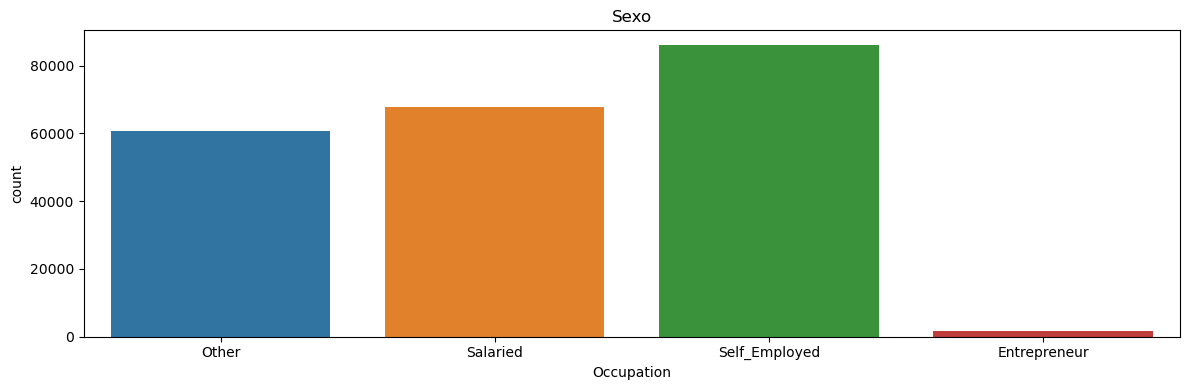

In [50]:
# Veamos las proporciones en algunas variables:
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
sns.countplot(data=creditCardLeadDf, x='Occupation', ax=axes)
axes.set_title('Sexo')
plt.tight_layout()

# Show the plot
plt.show()

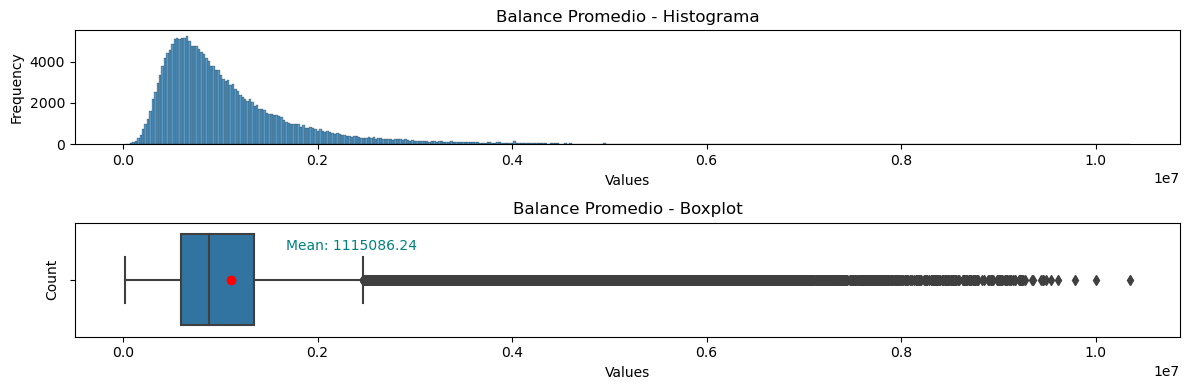

In [44]:
# veamos histogramas y boxplots para las dos variables numéricas que tienen nuestros datos
fig, axes = plt.subplots(2, 1, figsize=(12, 4))

data = creditCardLeadDf['Avg_Account_Balance']
titulo = 'Balance Promedio'

sns.histplot(data,ax=axes[0])
axes[0].set_xlabel('Values')
axes[0].set_ylabel('Frequency')
axes[0].set_title(titulo+' - Histograma')

sns.boxplot(x=data, ax=axes[1])
mean_value = np.mean(data)
axes[1].plot(mean_value, 0,  marker='o', color='red', label='Mean')
axes[1].text(mean_value+mean_value/2, -.3, f"Mean: {mean_value:.2f}", color='teal', ha='left', va='center')
axes[1].set_xlabel('Values')
axes[1].set_ylabel('Count')
axes[1].set_title(titulo+' - Boxplot')
#axes[1].legend()


plt.tight_layout()
plt.show()


42.80731515711645

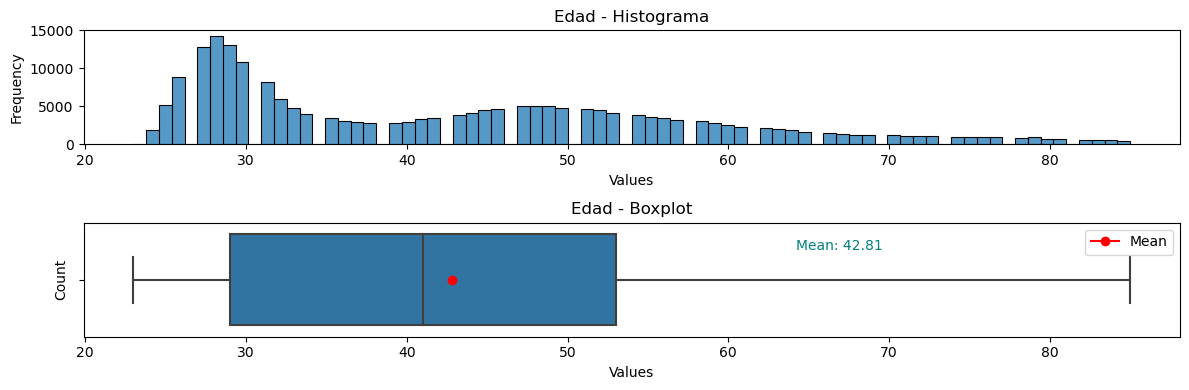

In [43]:
# veamos histogramas y boxplots para las dos variables numéricas que tienen nuestros datos
fig, axes = plt.subplots(2, 1, figsize=(12, 4))

data = creditCardLeadDf['Age']
titulo = 'Edad'

sns.histplot(data,ax=axes[0])
axes[0].set_xlabel('Values')
axes[0].set_ylabel('Frequency')
axes[0].set_title(titulo+' - Histograma')

sns.boxplot(x=data, ax=axes[1])
mean_value = np.mean(data)
axes[1].plot(mean_value, 0,  marker='o', color='red', label='Mean')
axes[1].text(mean_value+mean_value/2, -.3, f"Mean: {mean_value:.2f}", color='teal', ha='left', va='center')
axes[1].set_xlabel('Values')
axes[1].set_ylabel('Count')
axes[1].set_title(titulo+' - Boxplot')
#axes[1].legend()


plt.tight_layout()
plt.show()


## Selección de clasificador

### Arboles de decicion: ver las variables
### clustering para ver los clientes parecidos